In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import cartopy.crs as ccrs  # Cartopy coordinate reference system
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

In [2]:
# Define data directories and models
data_dir = "../discharge_data"  
sim_dir = "CaMa_fin"
obs_dir = "Observational_data"
model='watergap2-2e'
sim_setup = [f'{model}_gswp3-w5e5_obsclim_histsoc_default_dis_global_daily_1901_2019.nc',
             f'ba_q50_{model}_gswp3-w5e5_obsclim_histsoc_default_dis_global_daily_1901_2019.nc',
             f'{model}_gswp3-w5e5_counterclim_histsoc_default_dis_global_daily_1901_2019.nc',
             f'ba_q50cf_{model}_gswp3-w5e5_counterclim_histsoc_default_dis_global_daily_1901_2019.nc']
labels = ["factual", "factual-ba","counterf", "counterf-ba","observed"]

# Read the NetCDF file for bias corrected data in an xarray.Dataset
try:
    print("reading in: ",labels[0],sim_setup[0])
    sim = xr.open_dataset(os.path.join(data_dir,sim_dir,sim_setup[0]))

    # Convert the xarray.Dataset to a pandas.DataFrame and reset index
    df_sim = sim.to_dataframe()

    # df_sim = df_sim.reset_index()
    df_sim = df_sim.rename(columns={'dis': labels[0]})

except Exception as e:
        print(f"Error processing {sim_setup[0]}: {e}")

reading in:  factual watergap2-2e_gswp3-w5e5_obsclim_histsoc_default_dis_global_daily_1901_2019.nc


In [3]:
# append discharge from other runs for the same model
for i, file in enumerate(sim_setup[1:]):
    print("reading in: ",labels[i+1],file)
    try:
        xa_int = xr.open_dataset(os.path.join(data_dir,sim_dir,file))
        df_int = xa_int.to_dataframe()
        df_sim = df_sim.merge(df_int['dis'], on=["time", "stationID"], how="outer")
        df_sim = df_sim.rename(columns={'dis': labels[i+1]})
    except Exception as e:
        print(f"Error processing {name}: {e}")

reading in:  factual-ba ba_q50_watergap2-2e_gswp3-w5e5_obsclim_histsoc_default_dis_global_daily_1901_2019.nc
reading in:  counterf watergap2-2e_gswp3-w5e5_counterclim_histsoc_default_dis_global_daily_1901_2019.nc
reading in:  counterf-ba ba_q50cf_watergap2-2e_gswp3-w5e5_counterclim_histsoc_default_dis_global_daily_1901_2019.nc


In [4]:
# # Read in and append observational dataframe
try:
    obs = xr.open_dataset(os.path.join(data_dir,obs_dir,'Obs.nc'))
    # Convert the xarray.Dataset to a pandas.DataFrame
    df_obs = obs.to_dataframe()
    df_sim = df_sim.merge(df_obs['Discharge'], on=["time", "stationID"], how="outer")
    df_sim = df_sim.rename(columns={'Discharge': labels[-1]})
except Exception as e:
    print(f"Error processing obs: {e}")

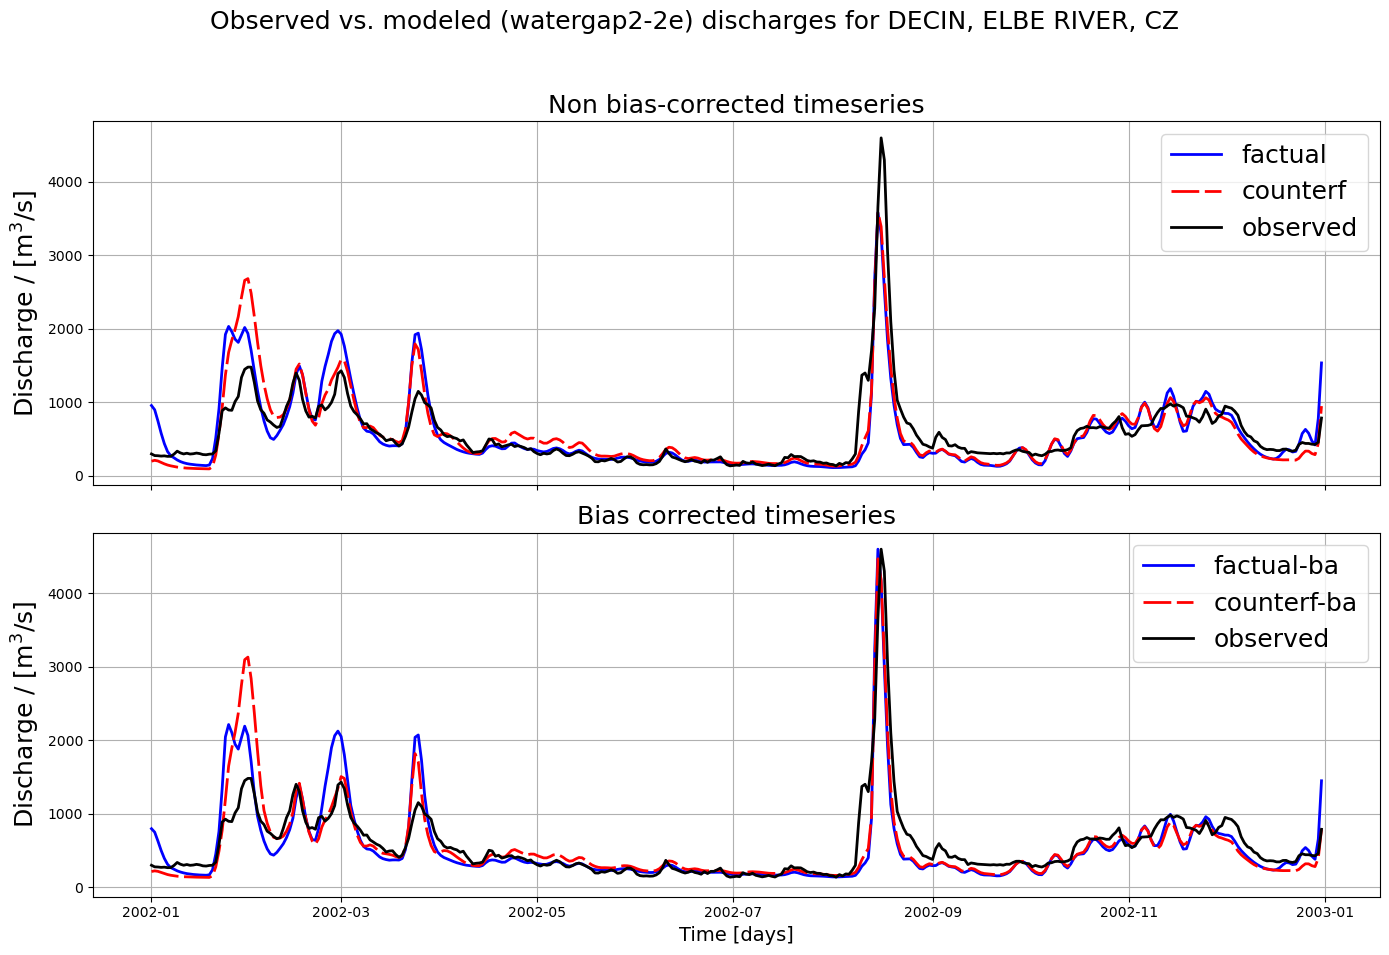

In [12]:
stationID = 6140400
discharges = df_sim.xs(stationID, level='stationID')
station_name, river, alpha2 = discharges['station'].iloc[0], discharges['river'].iloc[0], discharges['ctr'].iloc[0]
colors = ['blue', 'red', 'black']
ls = ['-', '--', '-.']
lw = [2, 2, 2]
dashes = [[], [10, 2], []]

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True, sharey=True)

# Upper plot: factual, counterfactual, and observed
for i, name in enumerate(['factual', 'counterf', 'observed']):
    axs[0].plot(discharges.loc['2002'].index, discharges.loc['2002'][name], label=name, color=colors[i], lw=lw[i], ls=ls[i], dashes=dashes[i])
axs[0].legend(fontsize=18)
axs[0].set_title('Non bias-corrected timeseries', fontsize=18)
axs[0].set_ylabel(r'Discharge / [m$^3$/s]', fontsize=18)
axs[0].grid(True)

# Bottom plot: factual-ba, counterfactual-ba, and observed
for i, name in enumerate(['factual-ba', 'counterf-ba', 'observed']):
    axs[1].plot(discharges.loc['2002'].index, discharges.loc['2002'][name], label=name, color=colors[i], lw=lw[i], ls=ls[i], dashes=dashes[i])
axs[1].legend(fontsize=18)
axs[1].set_title('Bias corrected timeseries', fontsize=18)
axs[1].set_xlabel('Time [days]', fontsize=14)
axs[1].set_ylabel(r'Discharge / [m$^3$/s]', fontsize=18)
axs[1].grid(True)

fig.suptitle(f'Observed vs. modeled ({model}) discharges for {station_name}, {river}, {alpha2}', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


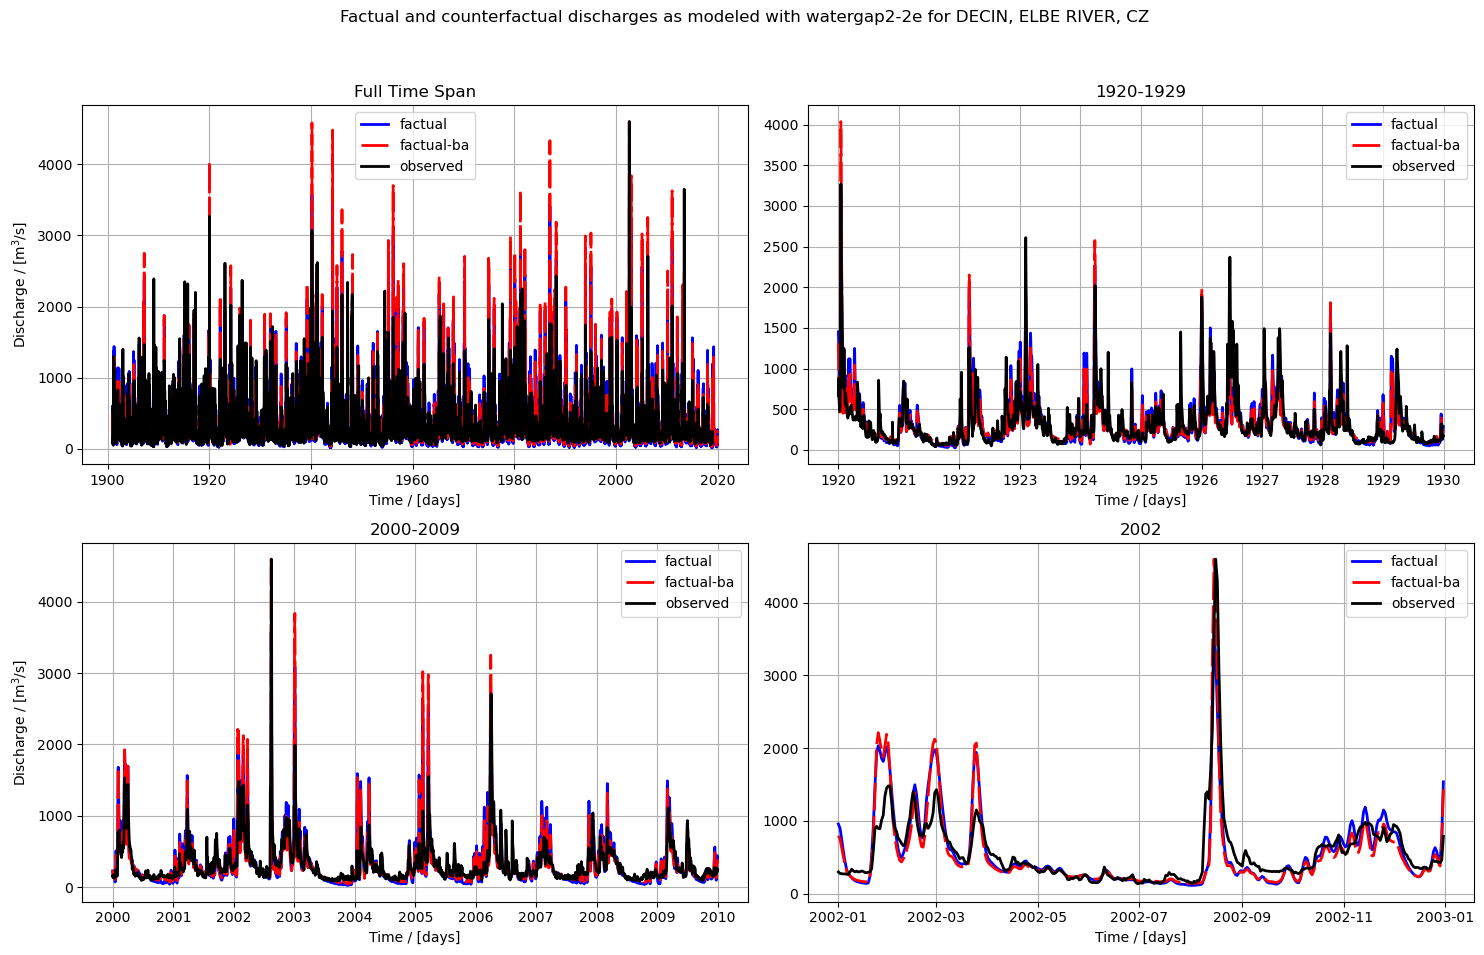

In [6]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=False)

setups = ['factual','factual-ba','observed']
# Upper left plot: Full time axis
axs[0, 0].set_title('Full Time Span')
for i, name in enumerate(setups):
    axs[0, 0].plot(discharges.index, discharges[name], label=name, color=colors[i],lw=lw[i], ls=ls[i], dashes=dashes[i])
axs[0, 0].set_xlabel('Time / [days]')
axs[0, 0].set_ylabel(r'Discharge / [m$^3$/s]')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Upper right plot: Decade 1920-1929
axs[0, 1].set_title('1920-1929')
for i, name in enumerate(setups):
    axs[0, 1].plot(discharges.loc['1920':'1929'].index, discharges.loc['1920':'1929'][name], label=name, color=colors[i],lw=lw[i], ls=ls[i], dashes=dashes[i])
axs[0, 1].set_xlabel('Time / [days]')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Lower left plot: Decade 2000-2009
axs[1, 0].set_title('2000-2009')
for i, name in enumerate(setups):
    axs[1, 0].plot(discharges.loc['2000':'2009'].index, discharges.loc['2000':'2009'][name], label=name, color=colors[i],lw=lw[i], ls=ls[i], dashes=dashes[i])
axs[1, 0].set_xlabel('Time / [days]')
axs[1, 0].set_ylabel(r'Discharge / [m$^3$/s]')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Lower right plot: Year 2002
axs[1, 1].set_title('2002')
for i, name in enumerate(setups):
    axs[1, 1].plot(discharges.loc['2002'].index, discharges.loc['2002'][name],label=name, color=colors[i],lw=lw[i], ls=ls[i], dashes=dashes[i])
axs[1, 1].set_xlabel('Time / [days]')
axs[1, 1].legend()
axs[1, 1].grid(True)

fig.suptitle(f'Factual and counterfactual discharges as modeled with {model} for {station_name}, {river}, {alpha2}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

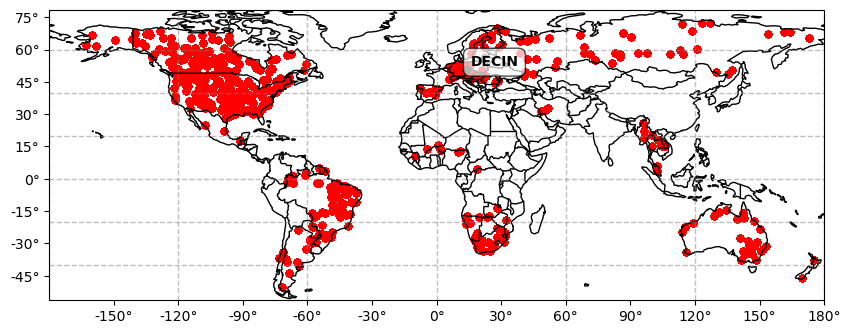

In [7]:
# Create a figure with a specific projection (PlateCarree is a standard lat/lon projection)
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines to the plot for better visibility of the continents
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Add latitude and longitude gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# Disable all labels on the gridlines
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
# Set the ticks for latitude and longitude
ax.set_xticks(range(-180, 181, 30), crs=ccrs.PlateCarree())  # Longitude ticks
ax.set_yticks(range(-90, 91, 15), crs=ccrs.PlateCarree())    # Latitude ticks

# Set labels for the ticks
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))


# Plot each point in the DataFrame (lat, lon) on the map
ax.scatter(df_sim['stat_lon'], df_sim['stat_lat'], color='red', s=20, transform=ccrs.PlateCarree())
ax.scatter(discharges['stat_lon'].iloc[0], discharges['stat_lat'].iloc[0], color=['black'],s=25,transform=ccrs.PlateCarree())
# Add text with thicker font and a white background rectangle
ax.text(discharges['stat_lon'].iloc[0] + 1.5, discharges['stat_lat'].iloc[0] + 1.5, discharges['station'].iloc[0],
    transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.5'))
# for i, row in df.iterrows():
#    ax.text(row['Longitude'] + 2, row['Latitude'] + 2, row['City'], transform=ccrs.PlateCarree(), fontsize=12)

# Display the map
plt.show()